In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve, brentq
from scipy.constants import pi

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.materials import *
os.chdir(cwd)

In [3]:
def beta_f(kx, ky, n, k0):
    return np.sqrt(n**2*k0**2 - kx**2 - ky**2)

In [4]:
def symmetric_slab_equations(X, n0, n1, d, wl, mode):
    '''
    Nonlinear equations to be solved
    '''
    k0 = 2*pi/wl #wavevector
    Rsqr = (k0*d/2)**2*(n1**2-n0**2)

    Y = np.sqrt(np.abs(Rsqr - X**2))

    if mode=='TE even':
        F = X*np.tan(X) - Y
    elif mode=='TE odd':
        F = X/np.tan(X) + Y
    elif mode=='TM even':
        F = X*np.tan(X)*(n0/n1)**2 - Y
    elif mode=='TM odd':
        F = X/np.tan(X)*(n0/n1)**2 + Y
    else:
        print('Wrong mode selection....?')
        F = 0

    return F

In [5]:
def neff_symmetric_slab(n0, n1, d, wl, mode='TE even', order=0):
    '''
    n0: cladding index 
    n1: slab index 
    d: slab thickness
    wl: wavelength
    mode: desired mode 'TE even', 'TE odd', 'TM even', 'TM odd'
    order: mode number integer
    '''
    k0 = 2*pi/wl #wavevector
    R = np.sqrt((k0*d/2)**2*(n1**2-n0**2))
    #Solve for Normalized variables: X=kx*d/2, Y=a*d/2

    #Initial condition
    if mode=='TE even' or 'TM even':
        xmin = 0
        xmax = min(R, pi/2*(order+1))
    elif mode=='TE odd' or 'TM odd':
        xmin = pi/2
        xmax = min(R, pi*(order+1))
    else:
        print('Wrong mode selection....?')

    #Solve equations
    X = brentq(symmetric_slab_equations, xmin, xmax, (n0, n1, d, wl, mode))
    kx = X*2/d
    beta = beta_f(kx, 0, n1, k0)
    neff = beta/k0
    return neff

In [6]:
def asymmetric_slab_eqs(x, n0, n1, n2, d, wl, mode='TE', order=0):
    '''
    Nonlinear equations to be solved
    '''
    k0 = 2*pi/wl #wavevector
    Rsqr_1 = (k0*d)**2*(n1**2-n0**2)
    Rsqr_2 = (k0*d)**2*(n1**2-n2**2)

    X = x
    Y = np.sqrt(np.abs(Rsqr_1 - X**2))
    Y2 = np.sqrt(np.abs(Rsqr_2 - X**2))

    if mode=='TM':
        Y = Y*(n1/n0)**2
        Y2 = Y2*(n1/n2)**2

    F = np.arctan(Y/X) + np.arctan(Y2/X) - X + order*pi

    return F

In [7]:
def neff_asymmetric_slab(n0, n1, n2, d, wl, mode='TE', order=0):
    '''
    n0: cladding index 
    n1: slab index 
    n2: lower cladding index
    d: slab thickness
    wl: wavelength
    mode: desired mode 'TE' or 'TM'
    order: mode number integer
    '''
    k0 = 2*pi/wl #wavevector
    Rsqr_1 = np.sqrt((k0*d)**2*(n1**2-n0**2))
    Rsqr_2 = np.sqrt((k0*d)**2*(n1**2-n2**2))

    #Solve for Normalized variables: X=kx*d, Y=a*d, Y2=a2*d
    xmin = 1e-6 + order*pi
    xmax = min(Rsqr_1, Rsqr_2, pi*(order+1))

    #Solve equations
    X = brentq(asymmetric_slab_eqs, xmin, xmax, (n0, n1, n2, d, wl, mode, order))
    kx = X/d
    beta = beta_f(kx, 0, n1, k0)
    neff = beta/k0
    return neff

In [8]:
def singlemode_symmetric(n0, n1, wl):
    #Returns thickness for single mode operation
    d = wl/2
    if n1>n0:
        d = d/np.sqrt(n1**2 - n0**2)
    else:
        d = d/np.sqrt(n0**2 - n1**2)
    return d

def singlemode_asymmetric(n0, n1, n2, wl):
    #Returns thickness for single mode operation
    #n1>n2>n0
    d = wl/2
    d = d/np.sqrt(n1**2 - n2**2)
    d = d*( 1 + (1/pi)*np.arctan(np.sqrt(n2**2 - n0**2)/np.sqrt(n1**2 - n2**2)))
    return d

## Example 1

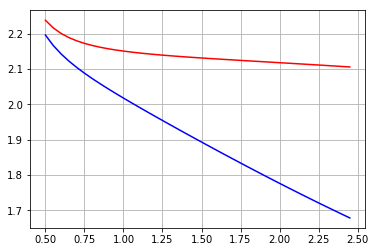

In [12]:
wl = np.arange(0.5,2.5,0.05)

n0 = 1
d = 0.5

neff = np.zeros(wl.shape)
d_sm = np.zeros(wl.shape)
n1 = np.zeros(wl.shape)

for kw in range(wl.size):
    n1[kw] = refractive_index('LN_MgO_e', wl[kw])
    neff[kw]= neff_symmetric_slab(n0, n1[kw], d, wl[kw], mode='TE even', order=0)
    
plt.plot(wl, n1, 'r', wl, neff, 'b');
plt.grid()

## Example 2

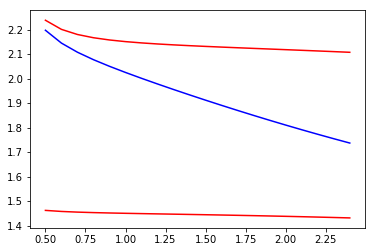

In [15]:
del wl, n0, n1, d, neff

wl = np.arange(0.5,2.5,0.1)

n0 = 1
n1 = refractive_index('LN_MgO_e', wl)
n2 = refractive_index('SiO2', wl)
d = 0.5

neff = np.zeros(wl.shape)
for kw in range(wl.size):
    neff[kw]= neff_asymmetric_slab(n0, n1[kw], n2[kw], d, wl[kw], mode='TE even', order=0)
    
plt.plot(wl, n1, 'r', wl, n2, 'r', wl, neff, 'b');

## Example 3

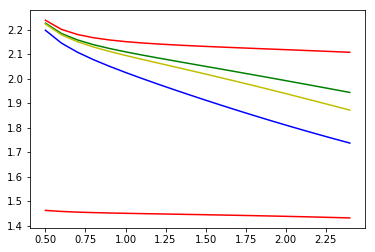

In [24]:
#del wl, n0, n1, d, neff

wl = np.arange(0.5,2.5,0.1)

n0 = 1
n1 = refractive_index('LN_MgO_e', wl)
n2 = refractive_index('SiO2', wl)
dslab = 0.5
dridge = 1
wridge = 1.5

n_slab = np.zeros(wl.shape)
n_ridge = np.zeros(wl.shape)
neff = np.zeros(wl.shape)
for kw in range(wl.size):
    n_slab[kw]= neff_asymmetric_slab(n0, n1[kw], n2[kw], dslab, wl[kw], mode='TE even', order=0)
    n_ridge[kw]= neff_asymmetric_slab(n0, n1[kw], n2[kw], dridge, wl[kw], mode='TE even', order=0)
    neff[kw] = neff_symmetric_slab(n_slab[kw], n_ridge[kw], wridge, wl[kw], mode='TM even', order=0)
    
plt.plot(wl, n1, 'r', wl, n2, 'r', wl, n_slab, 'b', wl, n_ridge, 'g', wl, neff, 'y');

